In [0]:
import re

import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
url = 'https://raw.githubusercontent.com/k0nci/oznal/master/data/mbti_1.csv'

raw_data = pd.read_csv(url)
raw_data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'Being neat and tidy is often really all about...
freq,1832,1


In [0]:
data = raw_data['posts'].apply(lambda x: pd.Series([y.strip() for y in x.split('|||')])) \
                        .reset_index() \
                        .rename(columns={'index': 'user_id'}) \
                        .merge(raw_data, left_index=True, right_index=True) \
                        .drop(columns=['posts']) \
                        .melt(id_vars=['user_id', 'type'], value_name='post', var_name='post_id') \
                        .dropna(subset=['post']) \
                        .sort_values(by=['user_id', 'post_id']) \
                        .reset_index(drop=True)

data.describe()

,user_id
count,422845.000000
mean,4340.423529
std,2506.825488
min,0.000000
25%,2165.000000
50%,4345.000000
75%,6515.000000
max,8674.000000


In [0]:
data['I'] = data['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
data['E'] = data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)

data['N'] = data['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
data['S'] = data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)

data['T'] = data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
data['F'] = data['type'].apply(lambda x: 1 if x[2] == 'F' else 0)

data['J'] = data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
data['P'] = data['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

data.head()

,user_id,type,post_id,post,I,E,N,S,T,F,J,P
0,0,INFJ,0,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,1,0,0,1,1,0
1,0,INFJ,1,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,0,1,0,0,1,1,0
2,0,INFJ,2,enfp and intj moments https://www.youtube.com...,1,0,1,0,0,1,1,0
3,0,INFJ,3,What has been the most life-changing experienc...,1,0,1,0,0,1,1,0
4,0,INFJ,4,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,1,0,1,0,0,1,1,0


In [0]:
data['urls_count'] = data['post'].apply(lambda x: len(re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', x)))

data['words_count'] = data['post'].apply(lambda x: len(x.split()))
data['sentences_count'] = data['post'].apply(lambda x: len(sent_tokenize(x)))
data['words_per_sentence'] = data['words_count'] / data['sentences_count']

In [0]:
data['post'] = data['post'].apply(lambda x: x.lower().strip())
data['post'] = data['post'].apply(lambda x: re.sub(r" +", " ", x))

data['post'] = data['post'].apply(lambda x: re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", x))
data['post'] = data['post'].apply(lambda x: re.sub(r"/[-\/\\^$*+?.()|[\]{}]/g", "", x))
data['post'] = data['post'].apply(lambda x: re.sub(r"[iex\*][nsx\*][ftx\*][pjx\*]", "", x))
data['post'] = data['post'].apply(lambda x: re.sub(r"[0-9]+", "", x))
data['post'] = data['post'].apply(lambda x: re.sub(r"#[a-zA-Z]+", "", x))
data['post'] = data['post'].apply(lambda x: re.sub(r"['\";,.?!\/\\()\[\]]", "", x))
data['post'] = data['post'].apply(lambda x: re.sub(r"[-_]", " ", x))

data = data[data['post'] != '']

In [0]:
def merge_post(series, sep=' '):
  return series.str.cat(sep=sep)

user_data = data.groupby('user_id').agg({
    'I': 'max',
    'post': merge_post,
    'words_count': ['mean', 'var'],
    'sentences_count': 'mean'
})

user_data.columns = ["_".join(y) for y in user_data.columns.ravel()]

user_data.loc[user_data['words_count_var'].isnull(), 'words_count_var'] = 0

user_data.rename(
    inplace=True,
    columns={
        'I_max': 'I',
        'post_merge_post': 'posts',
        'words_count_mean': 'words_per_post',
        'sentences_count_mean': 'sentences_per_post'
    }    
)

cleaned_word_count = user_data['posts'].apply(lambda x: len(x.split()))

user_data = user_data[cleaned_word_count > 5].reset_index(drop=True)

In [0]:
sid = SentimentIntensityAnalyzer()

sentiment_data = pd.DataFrame([sid.polarity_scores(x) for x in user_data['posts']])

user_data = user_data.join(sentiment_data)

In [0]:
user_data.head()

,I,posts,words_per_post,words_count_var,sentences_per_post,compound,neg,neu,pos
0,1,and moments sportscenter not top ten plays ...,16.416667,124.821429,1.638889,0.9735,0.088,0.777,0.134
1,0,im finding the lack of me in these posts very ...,25.872340,165.852914,2.723404,0.9994,0.077,0.721,0.202
2,1,good one of course to which i say i kno...,20.880952,155.570848,1.976190,0.9983,0.089,0.724,0.187
3,1,dear i enjoyed our conversation the other day...,22.260000,185.543265,2.300000,0.9979,0.063,0.798,0.138
4,0,youre fired thats another silly misconception ...,21.553191,187.643848,2.382979,0.9456,0.150,0.685,0.165


In [0]:
y = user_data.I
X = user_data.drop(columns='I')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
def lemmatize_stem(posts):
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  
  res = []
  for post in posts:
    words = word_tokenize(post)
    words = [lemmatizer.lemmatize(word) for word in words]
    words = [stemmer.stem(word) for word in words]
    res.append(' '.join(words))
    
  return res


train_documents = lemmatize_stem(X_train.posts)
test_documents = lemmatize_stem(X_test.posts)

In [0]:
# train_documents = X_train.posts
# test_documents = X_test.posts

# TF-IDF

In [0]:
stop_words = set(stopwords.words('english')) 

NGRAM_RANGE = (1, 2)
TOP_K = 1500
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 2

vectorizer_params = {
  'ngram_range': NGRAM_RANGE,
  'dtype': 'int32',
  'strip_accents': 'unicode',
  'decode_error': 'replace',
  'analyzer': TOKEN_MODE, 
  'min_df': MIN_DOCUMENT_FREQUENCY,
  'stop_words': stop_words
}

vectorizer = TfidfVectorizer(**vectorizer_params)

train_features_tfidf = vectorizer.fit_transform(train_documents)
test_features_tfidf = vectorizer.transform(test_documents)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [0]:
selector = SelectKBest(f_classif, k=min(TOP_K, train_features_tfidf.shape[1]))
selector.fit(train_features_tfidf, y_train)

train_features_tfidf = selector.transform(train_features_tfidf).astype('float32')
test_features_tfidf = selector.transform(test_features_tfidf).astype('float32')

In [0]:
svd = TruncatedSVD(n_components=64)

train_features_tfidf = svd.fit_transform(train_features_tfidf)
test_features_tfidf = svd.transform(test_features_tfidf)

In [0]:
X_train_tfidf = X_train.drop(columns='posts')
X_test_tfidf = X_test.drop(columns='posts')

X_train_tfidf.reset_index(drop=True, inplace=True)
X_test_tfidf.reset_index(drop=True, inplace=True)

train_features_tfidf = pd.SparseDataFrame(data=train_features_tfidf)
test_features_tfidf = pd.SparseDataFrame(data=test_features_tfidf)

X_train_tfidf = pd.concat([X_train_tfidf, train_features_tfidf.to_dense()], axis=1)
X_test_tfidf = pd.concat([X_test_tfidf, test_features_tfidf.to_dense()], axis=1)

In [0]:
class_ratio = (y_train == 0).sum()/(y_train == 1).sum()

model_tfidf = XGBClassifier(scale_pos_weight=class_ratio)
model_tfidf.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.2974943904263276,
       seed=None, silent=True, subsample=1)

In [0]:
y_pred = model_tfidf.predict(X_test_tfidf)

In [0]:
confusion_matrix(y_test, y_pred)

array([[231, 177],
       [414, 913]])

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.57      0.44       408
           1       0.84      0.69      0.76      1327

   micro avg       0.66      0.66      0.66      1735
   macro avg       0.60      0.63      0.60      1735
weighted avg       0.72      0.66      0.68      1735



In [0]:
accuracy_score(y_test, y_pred)

0.6593659942363113

In [0]:
importances = pd.Series(model_tfidf.feature_importances_, index=X_train_tfidf.columns)

importances.nlargest(10)

2           0.052869
6           0.036285
1           0.027283
7           0.026034
pos         0.024261
12          0.024197
compound    0.022559
4           0.021161
0           0.021069
45          0.020011
dtype: float32

# Doc2Vec

In [0]:
train_documents_tagged = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(train_documents)]

In [0]:
doc2vec = Doc2Vec(train_documents_tagged, vector_size=64, window=3, min_count=2, workers=4)

train_features_doc2vec = [doc2vec.infer_vector(words) for words, tags in train_documents_tagged]
test_features_doc2vec = [doc2vec.infer_vector(doc.split()) for doc in test_documents]

In [0]:
X_train_doc2vec = X_train.drop(columns='posts')
X_test_doc2vec = X_test.drop(columns='posts')

X_train_doc2vec.reset_index(drop=True, inplace=True)
X_test_doc2vec.reset_index(drop=True, inplace=True)

train_features_doc2vec = pd.DataFrame(data=train_features_doc2vec)
test_features_doc2vec = pd.DataFrame(data=test_features_doc2vec)

X_train_doc2vec = pd.concat([X_train_doc2vec, train_features_doc2vec], axis=1)
X_test_doc2vec = pd.concat([X_test_doc2vec, test_features_doc2vec], axis=1)

Resample zhorsuje vysledky, vahovanie funguje lepsie

In [0]:
# X_train_doc2vec.drop(columns='words_count_var', inplace=True)
# X_test_doc2vec.drop(columns='words_count_var', inplace=True)

# sm = SMOTETomek()
# X_train_doc2vec, y_train_doc2vec = sm.fit_resample(X_train_doc2vec, y_train)

In [0]:
class_ratio = (y_train == 0).sum()/(y_train == 1).sum()

gbdt_doc2vec = XGBClassifier(scale_pos_weight=class_ratio)
gbdt_doc2vec.fit(X_train_doc2vec, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.2974943904263276,
       seed=None, silent=True, subsample=1)

In [0]:
y_pred = model_doc2vec.predict(X_test_doc2vec)

NameError: ignored

In [0]:
confusion_matrix(y_test, y_pred)

In [0]:
print(classification_report(y_test, y_pred))

In [0]:
accuracy_score(y_test, y_pred)

In [0]:
importances = pd.Series(model_doc2vec.feature_importances_, index=X_train_doc2vec.columns)

importances.nlargest(10)

# TF-IDF + Doc2Vec


In [0]:
train_features_tfidf = pd.SparseDataFrame(data=train_features_tfidf).add_prefix('tfidf_')
test_features_tfidf = pd.SparseDataFrame(data=test_features_tfidf).add_prefix('tfidf_')

train_features_doc2vec = pd.DataFrame(data=train_features_doc2vec).add_prefix('doc2vec_')
test_features_doc2vec = pd.DataFrame(data=test_features_doc2vec).add_prefix('doc2vec_')

train_tfidf_doc2vec = pd.concat([train_features_tfidf, train_features_doc2vec], axis=1)
test_tfidf_doc2vec = pd.concat([test_features_tfidf, test_features_doc2vec], axis=1)

train_tfidf_doc2vec = pd.SparseDataFrame(train_tfidf_doc2vec)
test_tfidf_doc2vec = pd.SparseDataFrame(test_tfidf_doc2vec)

In [0]:
X_train_tfidf_doc2vec = X_train.drop(columns='posts')
X_test_tfidf_doc2vec = X_test.drop(columns='posts')

X_train_tfidf_doc2vec.reset_index(drop=True, inplace=True)
X_test_tfidf_doc2vec.reset_index(drop=True, inplace=True)

X_train_tfidf_doc2vec = pd.concat([X_train_tfidf_doc2vec, train_tfidf_doc2vec.to_dense()], axis=1)
X_test_tfidf_doc2vec = pd.concat([X_test_tfidf_doc2vec, test_tfidf_doc2vec.to_dense()], axis=1)

In [0]:
X_tsne = X_train_tfidf_doc2vec[:1000]
y_tsne = y_train[:1000]

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [0]:
X_2d = tsne.fit_transform(X_tsne)

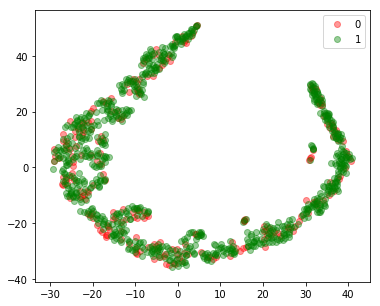

In [0]:
target_ids = [0, 1]

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g'
for i, c, label in zip(target_ids, colors, [0, 1]):
    plt.scatter(X_2d[y_tsne == i, 0], X_2d[y_tsne == i, 1], c=c, label=label, alpha=0.4)
plt.legend()
plt.show()

In [0]:
class_ratio = (y_train == 0).sum()/(y_train == 1).sum()

gbdt_params = {
    'colsample bytree': 0.9,
  'colsample_bylevel': 0.9,
  'gamma': 0.4,
  'learning_rate': 0.1,
#   'max_depth': 7,
  'min_child_weight': 7,
#   'n_estimators': 101,
  'reg_lambda': 10,
  'subsample': 0.7
}

scoring = {
    'f1_zero': make_scorer(f1_score, pos_label=0),
    'f1_macro': 'f1_macro'
}

In [0]:
param_opts = {
    'n_estimators': [75, 101, 125, 151],
#     'reg_lambda': [0.1, 0, 1, 10],
    'max_depth': range(4, 9),
#     'min_child_weight': range(4, 9),
#     'colsample_bylevel': [i/10.0 for i in range(6, 10)],
#     'colsample bytree': [i/10.0 for i in range(6, 10)],
#     'gamma': [i/10.0 for i in range(0, 5)],
#     'learning_rate': [0.05, 0.1, 0.2, 0.3],
#     'reg_lambda': [0.1, 0, 1, 10],
#     'subsample': [i/10.0 for i in range(6, 10)]
}

psearch = RandomizedSearchCV(XGBClassifier(scale_pos_weight=class_ratio, **gbdt_params), param_opts, 
                             scoring=scoring, cv=10, n_iter=10, refit='f1_macro',
                             n_jobs=2, verbose=10)
psearch.fit(X_train_tfidf_doc2vec, y_train)

psearch.best_params_, psearch.best_score_

In [0]:
param_opts = {
  'max_depth': [4, 5, 6, 7],
  'n_estimators': [91, 101, 111, 121]
}

psearch = GridSearchCV(XGBClassifier(scale_pos_weight=class_ratio, **gbdt_params), param_opts, 
                       scoring=scoring, cv=10, refit='f1_macro',
                       n_jobs=2, verbose=10)
psearch.fit(X_train_tfidf_doc2vec, y_train)

psearch.best_params_, psearch.best_score_

## GBDT

In [0]:
gbdt_params = {
    'colsample bytree': 0.9,
  'colsample_bylevel': 0.9,
  'gamma': 0.4,
  'learning_rate': 0.1,
  'max_depth': 7,
  'min_child_weight': 7,
  'n_estimators': 101,
  'reg_lambda': 10,
  'subsample': 0.7
}

gbdt_tfidf_doc2vec = XGBClassifier(scale_pos_weight=class_ratio, **gbdt_params)
gbdt_tfidf_doc2vec.fit(X_train_tfidf_doc2vec, y_train)

In [0]:
y_pred = gbdt_tfidf_doc2vec.predict(X_test_tfidf_doc2vec)

In [0]:
confusion_matrix(y_test, y_pred)

In [0]:
print(classification_report(y_test, y_pred))

In [0]:
accuracy_score(y_test, y_pred)

In [0]:
importances = pd.Series(gbdt_tfidf_doc2vec.feature_importances_, index=X_train_tfidf_doc2vec.columns)

importances.nlargest(10)

## SVM

In [0]:
svm_tfidf_doc2vec = SVC(class_weight='balanced', kernel='linear')
svm_tfidf_doc2vec.fit(X_train_tfidf_doc2vec, y_train)

In [0]:
y_pred = svm_tfidf_doc2vec.predict(X_test_tfidf_doc2vec)

In [0]:
confusion_matrix(y_test, y_pred)

In [0]:
print(classification_report(y_test, y_pred))

In [0]:
accuracy_score(y_test, y_pred)

## Random Forest

In [0]:
rf_tfidf_doc2vec = RandomForestClassifier(class_weight='balanced')
rf_tfidf_doc2vec.fit(X_train_tfidf_doc2vec, y_train)

In [0]:
y_pred = rf_tfidf_doc2vec.predict(X_test_tfidf_doc2vec)

In [0]:
confusion_matrix(y_test, y_pred)

In [0]:
print(classification_report(y_test, y_pred))

In [0]:
accuracy_score(y_test, y_pred)

In [0]:
X_train_doc2vec.head()

In [0]:
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers

X_trainek = X_train_doc2vec.drop(columns='words_per_post')
X_testek = X_test_doc2vec.drop(columns='words_per_post')

X_trainek = X_trainek.drop(columns='words_count_var')
X_testek = X_testek.drop(columns='words_count_var')

X_trainek = X_trainek.drop(columns='sentences_per_post')
X_testek = X_testek.drop(columns='sentences_per_post')

sm = SMOTE()
X_trainek, y_trainek = sm.fit_resample(X_trainek, y_train)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_trainek)

X_trainek = scaler.transform(X_trainek)
X_testek = scaler.transform(X_testek)

			 

model = models.Sequential()
model.add(layers.Dense(16, activation = "sigmoid", input_shape=(64, )))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation = "sigmoid"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

results = model.fit(
 X_trainek, y_trainek,
 epochs= 500,
 batch_size = 32,
 validation_data = (X_testek, y_test)
)
print("Test-Accuracy:", np.mean(results.history["val_acc"]))

In [0]:
y_pred = model.predict(X_testek)
y_pred = [1 if a > 0.5 else 0 for a in y_pred]

In [0]:
confusion_matrix(y_test, y_pred)

In [0]:
f1_score(y_test, y_pred, average='macro')